In [3]:
#!pip install torchmetrics
#!pip install timm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,utils
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
import cv2
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import timm
import torch.nn.functional as F

In [2]:
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
import kagglehub

path = kagglehub.dataset_download("mariaherrerot/aptos2019")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/aptos2019


In [4]:
list_dir = os.listdir(path)
print(list_dir)

['val_images', 'train_images', 'valid.csv', 'test.csv', 'train_1.csv', 'test_images']


In [5]:
train_images=path+'/train_images'*2
train_labels=pd.read_csv(path+'/train_1.csv')
valid_images=path+'/val_images'*2
valid_labels=pd.read_csv(path+'/valid.csv')
test_images=path+'/test_images'*2
test_labels=pd.read_csv(path+'/test.csv')

In [6]:
combined_data=pd.concat([train_labels,valid_labels,test_labels]).reset_index(drop=True)

In [7]:
combined_data.head()

,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0


In [10]:
combined_data['diagnosis'].value_counts()

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64

In [11]:
combined_data.shape

(3662, 2)

<Axes: xlabel='diagnosis', ylabel='count'>

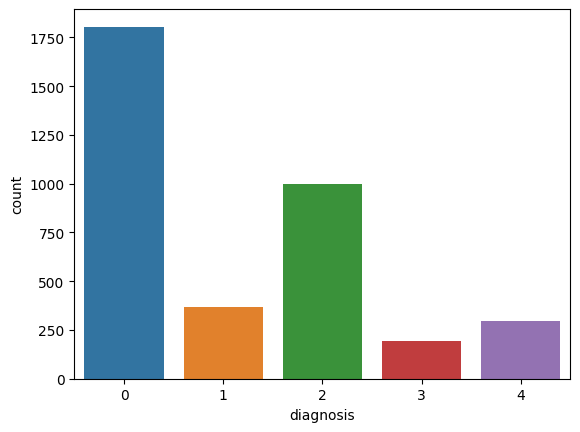

In [12]:
sns.countplot(combined_data,x='diagnosis')

In [13]:
image_dirs = [train_images,test_images,valid_images]
target_dir = "combined_images"
os.makedirs(target_dir, exist_ok=True)

for folder in image_dirs:
    for fname in os.listdir(folder):
        src = os.path.join(folder, fname)
        dst = os.path.join(target_dir, fname)
        if not os.path.exists(dst):
            shutil.copy2(src, dst)

In [14]:
target_size=500

In [15]:
data_downsampled=[]
for name,group in combined_data.groupby('diagnosis'):
  current_size=len(group)
  if current_size>target_size:
    data_downsampled.append(group.sample(target_size,random_state=42))
  else:
    data_downsampled.append(group)

downsampled_df=pd.concat(data_downsampled).reset_index(drop=True)
downsampled_df.head()

,id_code,diagnosis
0,ef5155990874,0
1,24de56d433cd,0
2,81914ceb4e74,0
3,a1b28bcbce00,0
4,c365c598ad4e,0


In [16]:
downsampled_df['diagnosis'].value_counts()

diagnosis
0    500
2    500
1    370
4    295
3    193
Name: count, dtype: int64

In [17]:
train_APTOS_df,val_test_APTOS_df=train_test_split(downsampled_df,test_size=0.2,random_state=42,stratify=downsampled_df['diagnosis'])
val_APTOS_df,test_APTOS_df=train_test_split(val_test_APTOS_df,test_size=0.5,random_state=42,stratify=val_test_APTOS_df['diagnosis'])

In [18]:
path = kagglehub.dataset_download("mariaherrerot/ddrdataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ddrdataset


In [19]:
list_dir = os.listdir(path)
images_path=os.path.join(path,list_dir[1],list_dir[1])
labels_path=os.path.join(path,list_dir[0])
print(images_path)
print(labels_path)

/kaggle/input/ddrdataset/DR_grading/DR_grading
/kaggle/input/ddrdataset/DR_grading.csv


In [20]:
labels_df=pd.read_csv(labels_path)
labels_df.head()

,id_code,diagnosis
0,20170413102628830.jpg,0
1,20170413111955404.jpg,0
2,20170413112015395.jpg,0
3,20170413112017305.jpg,0
4,20170413112528859.jpg,0


<Axes: xlabel='diagnosis', ylabel='count'>

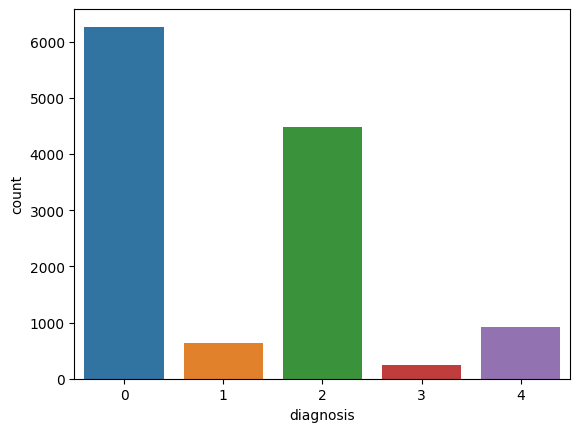

In [21]:
sns.countplot(x='diagnosis',data=labels_df)

In [22]:
labels_df['diagnosis'].value_counts()

diagnosis
0    6266
2    4477
4     913
1     630
3     236
Name: count, dtype: int64

In [23]:
size=800

In [24]:
new_data=[]
for name,group in labels_df.groupby('diagnosis'):
  targ_size=size-downsampled_df[downsampled_df['diagnosis']==name].shape[0]
  print(targ_size)
  if targ_size>0 :
    if targ_size>len(group):
      new_data.append(group)
    else:
      new_data.append(group.sample(targ_size,random_state=42))


300
430
300
607
505


In [25]:
collect_data=pd.concat(new_data).reset_index(drop=True)
collect_data.head()

,id_code,diagnosis
0,20170220085833145.jpg,0
1,20170329074906288.jpg,0
2,007-1981-100.jpg,0
3,007-0795-000.jpg,0
4,20170226223624346.jpg,0


In [26]:
for image in os.listdir(images_path):
  if image in collect_data['id_code'].values:
    src=os.path.join(images_path,image)
    dst=os.path.join(target_dir,image)
    if not os.path.exists(dst):
      shutil.copy2(src,dst)

In [27]:
train_DDR_df,val_test_DDR_df=train_test_split(collect_data,test_size=0.2,random_state=42,stratify=collect_data['diagnosis'])
val_DDR_df,test_DDR_df=train_test_split(val_test_DDR_df,test_size=0.5,random_state=42,stratify=val_test_DDR_df['diagnosis'])

In [28]:
train_df=pd.concat([train_APTOS_df,train_DDR_df]).reset_index(drop=True)
val_df=pd.concat([val_APTOS_df,val_DDR_df]).reset_index(drop=True)
test_df=pd.concat([test_APTOS_df,test_DDR_df]).reset_index(drop=True)

In [29]:
train_df['diagnosis'].value_counts()

diagnosis
1    640
0    640
2    640
4    640
3    342
Name: count, dtype: int64

In [30]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
class_weights=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(train_df['diagnosis']),y=train_df['diagnosis'])
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)

In [32]:
class DDRDataset(Dataset):
    def __init__(self,images_path,labels, transform=None,mode='rgb_clahe'):
       self.images_path=images_path
       self.labels=labels
       self.transform=transform
       self.mode=mode

    def apply_clahe_rgb(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        merged = cv2.merge((cl, a, b))
        return  merged

    def apply_green_clahe(self,image):
      green = image[:, :, 1]
      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
      green_enhanced = clahe.apply(green)
      return cv2.merge([green_enhanced]*3)

    def apply_circular_mask(self,image):
      h, w = image.shape[:2]
      center = (w // 2, h // 2)
      radius = min(center[0], center[1])

      Y, X = np.ogrid[:h, :w]
      dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
      mask = dist_from_center <= radius

      if image.ndim == 3:
          mask = np.stack([mask] * 3, axis=-1)

      masked_image = image.copy()
      masked_image[~mask] = 0
      return masked_image

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_name=self.labels.iloc[index,0]
        if '.' not in image_name:
            image_name=image_name+'.png'
        image_path=os.path.join(self.images_path,image_name)
        image=cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at path: {image_path}")
        label=int(self.labels.iloc[index,1])
        label=torch.tensor(label).long()
        if self.mode=='rgb_clahe':
            image=self.apply_clahe_rgb(image)
            image=cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        elif self.mode=="lab_clahe":
          image=self.apply_clahe_rgb(image)

        elif self.mode=="green_clahe":
          image=self.apply_green_clahe(image)
        else:
          image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #image=self.apply_circular_mask(image)
        if self.transform:
            image=self.transform(image)
        else:
            image=transforms.ToTensor()(image)
        return image,label


In [33]:
transforms_train=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=[-180, 180],
                                fill=0,interpolation=transforms.InterpolationMode.BICUBIC),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
     
])
transforms_test=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [34]:
train_data=DDRDataset(target_dir,train_df,transforms_train)
val_data=DDRDataset(target_dir,val_df,transforms_test)
test_data=DDRDataset(target_dir,test_df,transforms_test)
train_loader=DataLoader(train_data,batch_size=16,shuffle=True)
valid_loader=DataLoader(val_data,batch_size=16,shuffle=False)
test_loader=DataLoader(test_data,batch_size=16,shuffle=False)

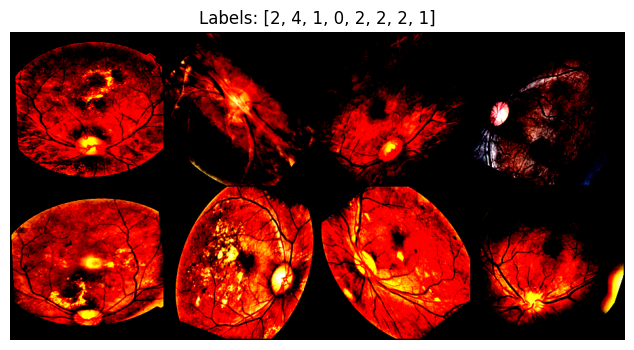

In [35]:
for images, labels in train_loader:
    grid_img =utils.make_grid(images[:8], nrow=4, padding=2)
    np_img = grid_img.permute(1, 2, 0).cpu().numpy()
    np_img = np_img.clip(0, 1)

    plt.figure(figsize=(10, 4))
    plt.imshow(np_img)
    plt.title(f"Labels: {labels[:8].tolist()}")
    plt.axis('off')
    plt.show()
    break

In [36]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device,
                num_epochs=10, checkpoint_path="mobilenet_dr.pth",
                early_stopping_patience=5):

    best_val_loss = float('inf')
    epochs_no_improve = 0
    l_val_loss = []
    l_train_loss = []

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")

        
        model.train()
        train_loss = 0.0
        train_correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = train_correct / total
        l_train_loss.append(avg_train_loss)
        print(f"Train Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}")
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / total
        val_acc = val_correct / total
        l_val_loss.append(avg_val_loss)
        print(f"Val Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")

       
        scheduler.step(avg_val_loss)

        # Save best model and reset early stopping counter
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Saved checkpoint at epoch {epoch+1}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epochs")

        # Check early stopping condition
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return l_train_loss, l_val_loss


In [37]:
def test_model(model, test_loader, criterion, device, num_classes=5):
    model.eval()

    accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    precision = Precision(task="multiclass", num_classes=num_classes, average='weighted').to(device)
    recall = Recall(task="multiclass", num_classes=num_classes, average='weighted').to(device)
    f1 = F1Score(task="multiclass", num_classes=num_classes, average='weighted').to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    print(f"Accuracy: {accuracy.compute().item():.4f}")
    print(f"Precision (weighted): {precision.compute().item():.4f}")
    print(f"Recall (weighted): {recall.compute().item():.4f}")
    print(f"F1 Score (weighted): {f1.compute().item():.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=3))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()

In [39]:
model2=timm.create_model('tf_efficientnet_b7', pretrained=True)
in_features = model2.classifier.in_features
model2.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features,5)
)
model2.to(device)

EfficientNet(
  (conv_stem): Conv2dSame(3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn1): BatchNormAct2d(
          64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNo

In [41]:
ceterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model2.parameters(),lr=0.001, weight_decay=1e-4)

In [42]:
train_loss,valid_loss=train_model(model2, train_loader, valid_loader, ceterion, optimizer, device, num_epochs=20,checkpoint_path="tf_efficientnet_b7.pth")


Epoch [1/20]


100%|██████████| 182/182 [08:19<00:00,  2.75s/it]


Train Loss: 1.3269, Accuracy: 0.4335


100%|██████████| 23/23 [00:47<00:00,  2.07s/it]


Val Loss: 1.1748, Accuracy: 0.4656
Saved checkpoint at epoch 1

Epoch [2/20]


100%|██████████| 182/182 [08:18<00:00,  2.74s/it]


Train Loss: 1.1181, Accuracy: 0.5169


100%|██████████| 23/23 [00:47<00:00,  2.07s/it]


Val Loss: 1.0101, Accuracy: 0.5620
Saved checkpoint at epoch 2

Epoch [3/20]


100%|██████████| 182/182 [08:18<00:00,  2.74s/it]


Train Loss: 1.0844, Accuracy: 0.5541


100%|██████████| 23/23 [00:47<00:00,  2.07s/it]


Val Loss: 1.0322, Accuracy: 0.5758
No improvement for 1 epochs

Epoch [4/20]


100%|██████████| 182/182 [08:18<00:00,  2.74s/it]


Train Loss: 1.0070, Accuracy: 0.5913


100%|██████████| 23/23 [00:47<00:00,  2.05s/it]


Val Loss: 0.8886, Accuracy: 0.6281
Saved checkpoint at epoch 4

Epoch [5/20]


100%|██████████| 182/182 [08:17<00:00,  2.74s/it]


Train Loss: 0.9659, Accuracy: 0.6044


100%|██████████| 23/23 [00:46<00:00,  2.04s/it]


Val Loss: 1.0026, Accuracy: 0.5620
No improvement for 1 epochs

Epoch [6/20]


100%|██████████| 182/182 [08:18<00:00,  2.74s/it]


Train Loss: 0.9632, Accuracy: 0.6196


100%|██████████| 23/23 [00:47<00:00,  2.05s/it]


Val Loss: 0.8496, Accuracy: 0.6501
Saved checkpoint at epoch 6

Epoch [7/20]


100%|██████████| 182/182 [08:17<00:00,  2.73s/it]


Train Loss: 0.9163, Accuracy: 0.6196


100%|██████████| 23/23 [00:47<00:00,  2.05s/it]


Val Loss: 0.9159, Accuracy: 0.6281
No improvement for 1 epochs

Epoch [8/20]


100%|██████████| 182/182 [08:17<00:00,  2.73s/it]


Train Loss: 0.9178, Accuracy: 0.6272


100%|██████████| 23/23 [00:47<00:00,  2.06s/it]


Val Loss: 0.8824, Accuracy: 0.6584
No improvement for 2 epochs

Epoch [9/20]


100%|██████████| 182/182 [08:17<00:00,  2.73s/it]


Train Loss: 0.8892, Accuracy: 0.6430


100%|██████████| 23/23 [00:47<00:00,  2.05s/it]


Val Loss: 0.9204, Accuracy: 0.6364
No improvement for 3 epochs

Epoch [10/20]


100%|██████████| 182/182 [08:16<00:00,  2.73s/it]


Train Loss: 0.7576, Accuracy: 0.6878


100%|██████████| 23/23 [00:47<00:00,  2.04s/it]


Val Loss: 0.7423, Accuracy: 0.7080
Saved checkpoint at epoch 10

Epoch [11/20]


100%|██████████| 182/182 [08:17<00:00,  2.74s/it]


Train Loss: 0.7155, Accuracy: 0.7154


100%|██████████| 23/23 [00:47<00:00,  2.05s/it]


Val Loss: 0.7112, Accuracy: 0.7300
Saved checkpoint at epoch 11

Epoch [12/20]


100%|██████████| 182/182 [08:17<00:00,  2.73s/it]


Train Loss: 0.7009, Accuracy: 0.7181


100%|██████████| 23/23 [00:47<00:00,  2.07s/it]


Val Loss: 0.7136, Accuracy: 0.7466
No improvement for 1 epochs

Epoch [13/20]


100%|██████████| 182/182 [08:16<00:00,  2.73s/it]


Train Loss: 0.6736, Accuracy: 0.7354


100%|██████████| 23/23 [00:47<00:00,  2.05s/it]


Val Loss: 0.7047, Accuracy: 0.7466
Saved checkpoint at epoch 13

Epoch [14/20]


100%|██████████| 182/182 [08:16<00:00,  2.73s/it]


Train Loss: 0.6409, Accuracy: 0.7440


100%|██████████| 23/23 [00:47<00:00,  2.05s/it]


Val Loss: 0.7005, Accuracy: 0.7355
Saved checkpoint at epoch 14

Epoch [15/20]


100%|██████████| 182/182 [08:16<00:00,  2.73s/it]


Train Loss: 0.6440, Accuracy: 0.7474


100%|██████████| 23/23 [00:47<00:00,  2.05s/it]


Val Loss: 0.7077, Accuracy: 0.7493
No improvement for 1 epochs

Epoch [16/20]


100%|██████████| 182/182 [08:15<00:00,  2.72s/it]


Train Loss: 0.6282, Accuracy: 0.7481


100%|██████████| 23/23 [00:46<00:00,  2.03s/it]


Val Loss: 0.7428, Accuracy: 0.7273
No improvement for 2 epochs

Epoch [17/20]


100%|██████████| 182/182 [08:14<00:00,  2.72s/it]


Train Loss: 0.5956, Accuracy: 0.7691


100%|██████████| 23/23 [00:46<00:00,  2.04s/it]


Val Loss: 0.7536, Accuracy: 0.7218
No improvement for 3 epochs

Epoch [18/20]


100%|██████████| 182/182 [08:15<00:00,  2.72s/it]


Train Loss: 0.5859, Accuracy: 0.7691


100%|██████████| 23/23 [00:46<00:00,  2.03s/it]


Val Loss: 0.7315, Accuracy: 0.7328
No improvement for 4 epochs

Epoch [19/20]


100%|██████████| 182/182 [08:14<00:00,  2.72s/it]


Train Loss: 0.5619, Accuracy: 0.7733


100%|██████████| 23/23 [00:47<00:00,  2.05s/it]

Val Loss: 0.7331, Accuracy: 0.7328
No improvement for 5 epochs
Early stopping triggered at epoch 19


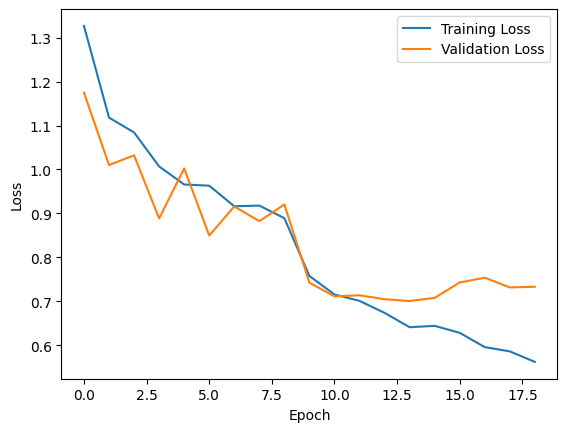

In [43]:
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

100%|██████████| 23/23 [00:51<00:00,  2.23s/it]


Accuracy: 0.6951
Precision (weighted): 0.6991
Recall (weighted): 0.6951
F1 Score (weighted): 0.6953

Classification Report:
              precision    recall  f1-score   support

           0      0.843     0.875     0.859        80
           1      0.655     0.688     0.671        80
           2      0.634     0.562     0.596        80
           3      0.519     0.636     0.571        44
           4      0.764     0.688     0.724        80

    accuracy                          0.695       364
   macro avg      0.683     0.690     0.684       364
weighted avg      0.699     0.695     0.695       364



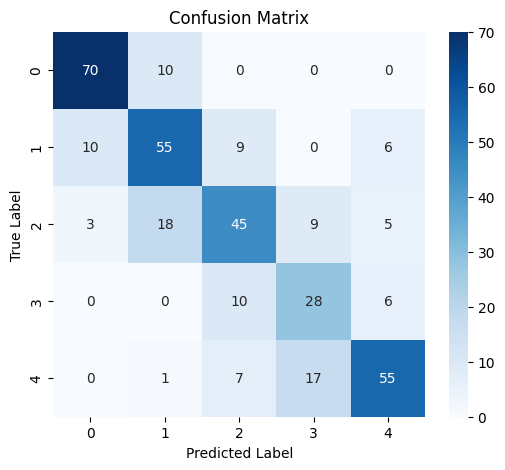

In [44]:
model2.load_state_dict(torch.load("tf_efficientnet_b7.pth"))
test_model(model2, test_loader, ceterion, device)